# Auto Encoder with RobustScaler

This code template is for Anomaly detection/outlier analysis using the Auto Encoder Algorithm. This template utilizes Auto Encoder implementation from the pyod library along with data rescaling using Robust Scaler.


### Required Packages

In [ ]:
!pip install plotly
!pip install pyod
!pip install tensorflow  

In [ ]:
import time
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
import tensorflow as tf
from pyod.models.deep_svdd import DeepSVDD
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings("ignore")

### Initialization

Filepath of CSV file

In [ ]:
file_path= ""

List of features which are  required for model training .

In [ ]:
features=[]

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [ ]:
df=pd.read_csv(file_path)
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,wrongfragment,hot,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,neptune
3,0,tcp,http,SF,232,8153,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,normal
4,0,tcp,http,SF,199,420,0,0,1,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,normal


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X.

In [ ]:
X=[features]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [ ]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature set.


In [ ]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])  
X=EncodeX(X)
X.head()

,duration,srcbytes,dstbytes,wrongfragment,hot,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,protocoltype_icmp,protocoltype_tcp,protocoltype_udp,service_IRC,service_Z39_50,...,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,232,8153,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,1,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Data Rescaling
In RobustScaler, data is scaled based on quantile ranges (i.e., IQR: Interquartile Range) rather than the median. Most machine learning estimators require a standardization of a dataset. A common method is to remove the mean and scale variance to the unit. Outliers, however, are sometimes harmful to the sample mean/variance. It is often better to use the median and the interquartile range for such cases.


[RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)


In [ ]:
X_Scaled=MaxAbsScaler().fit_transform(X)
X_Scaled=pd.DataFrame(data = X_Scaled,columns = X.columns)
X_Scaled.head()

,duration,srcbytes,dstbytes,wrongfragment,hot,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,protocoltype_icmp,protocoltype_tcp,protocoltype_udp,service_IRC,service_Z39_50,...,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_SF,flag_SH
0,0.0,1.741627,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.077876,-0.357143,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,-0.586592,-0.087398,-0.192708,0.071429,2.000,0.0,0.00,0.00,0.05,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.421053,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.428571,0.0,0.0,0.0,0.0,-1.000000,2.500000,0.00,0.000000,-0.184959,-0.369792,8.214286,10.875,0.0,0.00,0.00,0.00,0.00,-1.666667,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.137799,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.778761,-0.071429,1.0,1.0,0.0,0.0,-1.032609,1.166667,0.00,0.000000,-0.083333,-0.265625,0.357143,-0.125,0.0,1.00,1.00,0.00,0.00,-0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0
3,0.0,0.750239,16.529143,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056637,-0.142857,0.2,0.2,0.0,0.0,0.000000,0.000000,0.00,-1.256983,0.847561,0.671875,-0.357143,0.250,2.0,0.03,0.01,0.00,0.01,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.623923,0.851495,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120354,1.785714,0.0,0.0,0.0,0.0,0.000000,0.000000,0.09,0.000000,0.847561,0.671875,-0.357143,-0.125,0.0,0.00,0.00,0.00,0.00,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Splitting

The train-test split is a procedure for evaluating the performance of an algorithm. The procedure involves taking a dataset and dividing it into two subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [ ]:
x_train,x_test, y_train, y_test=train_test_split(X_Scaled,y, test_size=0.2,random_state=123)

### Model
Deep One-Class Classifier with AutoEncoder (AE) is a type of neural networks for learning useful data representations in an unsupervised way. DeepSVDD trains a neural network while minimizing the volume of a hypersphere that encloses the network representations of the data, forcing the network to extract the common factors of variation

Tuning parameters
c (float, optional (default='forwad_nn_pass'))

Deep SVDD center, the default will be calculated based on network initialization first forward pass. To get repeated results set random_state if c is set to None.

use_ae (bool, optional (default=False)

The AutoEncoder type of DeepSVDD it reverse neurons from hidden_neurons if set to True.

hidden_neurons (list, optional (default=[64, 32]))

The number of neurons per hidden layers. if use_ae is True, neurons will be reversed eg. [64, 32] -> [64, 32, 32, 64, n_features]

hidden_activation (str, optional (default='relu'))

Activation function to use for hidden layers. All hidden layers are forced to use the same type of activation. See https://keras.io/activations/

output_activation (str, optional (default='sigmoid'))

Activation function to use for output layer. See https://keras.io/activations/

optimizer (str, optional (default='adam'))

String (name of optimizer) or optimizer instance. See https://keras.io/optimizers/

epochs (int, optional (default=100))

Number of epochs to train the model.

batch_size (int, optional (default=32))

Number of samples per gradient update.

contamination (float in (0., 0.5), optional (default=0.1))

The amount of contamination of the data set, i.e. the proportion of outliers in the data set. When fitting this is used to define the threshold on the decision function.

For more information

In [ ]:
model = DeepSVDD(contamination=0.3, epochs=10, batch_size=16)
model.fit(x_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 103)               10712     
_________________________________________________________________
dropout_6 (Dropout)          (None, 103)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 103)               10712     
_________________________________________________________________
dropout_7 (Dropout)          (None, 103)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 103)               10712     
_________________________________________________________________
dropout_8 (Dropout)          (None, 103)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 52)               

AutoEncoder(batch_size=32, contamination=0.05, dropout_rate=0.2, epochs=20,
      hidden_activation='relu', hidden_neurons=[103, 52, 52, 103],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f88910b5a70>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

### Anomaly Prediction

In [ ]:
result=x_test.copy(deep=True)
test_pred = model.predict(x_test)
result['Anomaly']=test_pred
result.head()

,duration,srcbytes,dstbytes,wrongfragment,hot,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,protocoltype_icmp,protocoltype_tcp,protocoltype_udp,service_IRC,service_Z39_50,...,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_SF,flag_SH,Anomaly
131,0.0,-0.137799,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.863717,-0.142857,0.0,0.0,1.0,1.0,-1.043478,1.000000,0.0,0.000000,-0.184959,-0.369792,0.642857,-0.125,0.0,0.0,0.0,1.0,1.0,-0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,1
203,0.0,3.134928,1.165737,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.084956,-0.428571,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,-0.107724,-0.286458,-0.071429,-0.125,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
50,0.0,1.018182,1.009630,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021239,0.214286,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.692737,0.847561,0.671875,-0.357143,0.000,2.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
585,0.0,22.411483,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.428571,0.0,0.0,0.0,0.0,-1.000000,5.166667,0.0,-0.960894,-0.184959,-0.359375,0.785714,2.750,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
138,0.0,3.812440,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.769912,18.285714,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.847561,0.671875,-0.357143,12.375,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Anomaly Visualization

#### Bar Plot

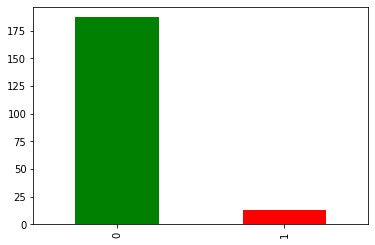

In [ ]:
result['Anomaly'].value_counts().plot(kind='bar',color=['green','red'])

**creator: Virat Chowdary, GitHub: [profile](https://github.com/viratchowdary21)**
